# Aditya Sawant's Version of SPN_IP_5Shot.ipynb

### Libraries Used

- tensorflow
- sklearn
- numpy
- matplotlib
- pandas
- scipy
- tensorflow_probability


## Initial setup

### Install Libraries

In [1]:
# %pip install scikit-learn numpy matplotlib scipy tensorflow_probability pandas tqdm plotly
# tensorflow[and-cuda]==2.10 [cuDNN 8.1.1 CUDA 11.2]

### Import Libraries

In [2]:
import random
import statistics
import os
from IPython.display import clear_output
  
from operator import truediv

import tensorflow as tf
print(tf.version.GIT_VERSION, tf.version.VERSION)
print(tf.test.is_built_with_cuda())
print("Number of GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Number of Devices Available: ", len(tf.config.experimental.list_physical_devices()))
# import tensorflow_probability as tfp
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K

from tensorflow.keras import Sequential, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.compat.v1.distributions import Bernoulli

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)
from datetime import date, datetime
from tqdm.auto import tqdm

from encoders.conv_sa import createModel
from lib.PrototypicalNetwork import Prototypical
from lib.misc import timeIt, plotData
from lib.Data import Data
from lib.Stats import Stats
from lib.Predict import *


v2.10.0-rc3-6-g359c3cdfc5f 2.10.0
True
Number of GPUs Available:  1
Number of Devices Available:  2


d:\HSI FSL BE-10 Major Project\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## Global Variables

In [3]:

# Test each code block individually
TEST_BLOCKS: bool = False
CWD: str = os.getcwd()
VERBOSE: bool = False

SAVE_REPORT: bool = True
SAVE_MODEL: bool = False
# Data Loading and Preprocessing


# Dataset Used : Indian Pines
DATASET: str = 'IP' # IP (indian_pines) PU (pavia_university) SA (salinas) HU (houston) 
PATH_TO_DATASET: str = CWD + '\\Datasets\\'

# PCA
PCA_COMPONENTS: int = 30 # Number of components to keep after PCA reduction

# Window size for forming image cubes
WINDOW_SIZE: int = 11

# Image dimensions after forming image cubes
IMAGE_WIDTH: int
IMAGE_HEIGHT: int
IMAGE_DEPTH: int
IMAGE_CHANNEL: int 
IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, IMAGE_CHANNEL = 11, 11, 30, 1

# Model Parameters

N_TIMES = 1 # Number of times to run the model. Internally, the model is runs each episode N_TIMES times

# Learning Rate
LEARNING_RATE: float = 0.00001

# Temprature Scaling
TAU: float = 1.8

# C (No. of Classes) K (No. of Samples per Class) N (No. of Patches per Class)
TRAIN_C: int = 5 # Number of classes to be used for training
TRAIN_K: int = 5 # Number of patches per class to be used for support during training
TRAIN_N: int = 15 # Number of patches per class to be used for query during training

TUNE_C: int = 3 # Number of classes to be used for testing
TUNE_K: int = 1 # Number of patches per class to be used for support during testing
TUNE_N: int = 4 # Number of patches per class to be used for query during testing

TEST_C: int = 3 # Number of classes to be used for testing
TEST_K: int = 5 # Number of patches per class to be used for support during testing
TEST_N: int = 5 # Number of patches per class to be used for query during testing

# ===================================
# DO NOT REMOVE THIS.
tC = 3   # classes in a test episode 
# Don't know this yet, probably used in the model to calculate loss
MC_LOSS_WEIGHT: int = 5 
# DIRECTLY USED IN PROTOTYPICAL NETWORK CLASS IN TESTING CASE
# ===================================

# Training Epochs 50
TRAINING_EPOCH: int = 50

# Training Episode 100
TRAINING_EPISODE: int = 100

# Tunning Epochs 41
TUNNING_EPOCH: int = 41

# Tunning Episode 100
TUNNING_EPISODE: int = 100

# Testing Epochs 1000
TESTING_EPOCH: int = 1000

# Metrics to be used for evaluation
train_loss = tf.metrics.Mean(name='train_loss')
train_acc = tf.metrics.Mean(name='train_accuracy')
tune_loss = tf.metrics.Mean(name='tune_loss')
tune_acc = tf.metrics.Mean(name='tune_accuracy')
test_loss = tf.metrics.Mean(name='test_loss')
test_acc = tf.metrics.Mean(name='test_accuracy')

trainingData = []
tunningData = []
testingData = []

run_folder =  f'{date.today()}' + '-' + f'{datetime.now().hour}_5_1' + '\\' 

checkpoint_dir = CWD + '\\saves\\' + run_folder + DATASET + '\\' + f'{TRAIN_K}_shot_way' + '\\Train'
checkpoint_prefix_train = os.path.join(checkpoint_dir, "ckpt")

checkpoint_dir1 = CWD + '\\saves\\' + run_folder + DATASET + '\\' + f'{TRAIN_K}_shot_way' + '\\Train\\Tune'
checkpoint_prefix_tune = os.path.join(checkpoint_dir1, "ckpt")

report_path = CWD + f'\\Reports\\Report_{date.today()}_{str(datetime.now()).split(".")[0].split()[1].replace(":", "-")}.txt'
model_save_path = CWD + '\\saves\\' + run_folder + DATASET + '\\' + f'{TRAIN_K}_shot_way' + '\\Train\\encoder.h5'


checkpoint = None  # To be used for loading checkpoints. Declared in the Main Block
ProtoModel = None  # Prototypical Network Object. Declared in the Main Block
model = None  # Model Object. Declared in the Main Block
optimizer = None  # Optimizer Object. Declared in the Main Block

## Data Loaders for Model

### For Training

In [4]:
def createTrainingEpisode(patches:list, labels:list, K:int, C:int, N:int ):
    """
    createTrainingEpisode creates a training episode for the N-way K-shot learning task.
    
    :param patches: list of all patches classified into different classes.
    :param labels: list of classes from which the traning episode is to be created.
    :param K: number of patches per class in the support set.
    :param C: number of classes in the training episode.
    :param N: number of patches per class in the query set.
    :return queryPatches, queryLabels, supportPatches, supportLabels: training episode
    
    Algorithm:
    - Select N classes from the list of labels. They should be unique.
    - For each class, select K+Q patches. They should be unique.
        - First K patches are support patches.
        - Last Q patches are query patches.
        - Append the support patches to supportPatches.
        - Append the query patches to queryPatches.
        - Append the class label to queryLabels Q times.
    - Shuffle the queryPatches and queryLabels in the same order.
    - Convert the queryPatches and supportPatches to tensors.
    
    """
    
    selectedLabels = random.sample(labels, C)
    supportPatches = []
    supportLabels = list(selectedLabels)
    queryPatches = []
    queryLabels = []
    
    for n in selectedLabels:
        sran_indices = np.random.choice(len(patches[n-1]),K,replace=False)  # for class no X-1: select K samples 
        supportPatches.extend( patches[n-1][sran_indices,:,:,:,:])
        qran_indices = np.random.choice(len(patches[n-1]),N,replace=False)  # N Samples for Query
        queryPatches.extend(patches[n-1][qran_indices,:,:,:,:])
        queryLabels.extend([n]*N)
    
    shuffled = list(zip(queryPatches, queryLabels))
    random.shuffle(shuffled)
    queryPatches, queryLabels = zip(*shuffled)
    
    queryPatches = tf.convert_to_tensor(np.reshape(np.asarray(queryPatches),(C*N,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH,IMAGE_CHANNEL)),dtype=tf.float32)
    supportPatches = tf.convert_to_tensor(np.reshape(np.asarray(supportPatches),(C*K,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH,IMAGE_CHANNEL)),dtype=tf.float32)
    
    return queryPatches, queryLabels, supportPatches, supportLabels


In [5]:
def train_step(support, query, support_labels, query_labels, K, C, N):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N,N_TIMES,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    
    # A gradient simply measures the change in all weights with regard to the change in error. You can also think of a gradient as the slope of a function. The higher the gradient, the steeper the slope and the faster a model can learn. But if the slope is zero, the model stops learning
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    train_loss(loss)
    train_acc(mean_accuracy)


In [6]:
@timeIt
def trainingEpochs(patches, labels, n_epochs, n_episodes):
    """
    trainingEpochs function trains the model for n_epochs and n_episodes.
    
    :param patches: image patches to be trained
    :param labels: corresponding labels to be used
    :param n_epochs: number of epochs
    :param n_episodes: number of episodes
    :return: None
    """
    
    template = 'Epoch {}/{}, Episode {}/{}, Train Loss: {:.2f}, Train Accuracy: {:.2f}'
    # for epoch in tqdm(range(n_epochs), desc='Epochs'):
    #     train_loss.reset_states()
    #     train_acc.reset_states()
    #     for episode in tqdm(range(n_episodes), desc=f'Episodes (Loss: {l:.2f}, Acc: {a:.2f})'):
    
    trainObj = tqdm(total=n_episodes * n_epochs, desc=f'Epoch 1/{n_epochs}, Episode 1/{n_episodes}')
    for epoch in range(n_epochs):
        train_loss.reset_states()
        train_acc.reset_states()
        for episode in range(n_episodes):
            queryPatches, queryLabels, supportPatches, supportLabels = createTrainingEpisode(patches, labels, TRAIN_K, TRAIN_C, TRAIN_N)
            train_step(supportPatches, queryPatches,supportLabels,  queryLabels, TRAIN_K, TRAIN_C, TRAIN_N)
            # clear_output(wait=True)
            trainObj.set_description(
                f'Epoch {epoch+1}/{n_epochs}, Episode {episode+1}/{n_episodes} (Loss: {train_loss.result().numpy()*100:.2f}, Acc: {train_acc.result().numpy()*100:.2f})')
            trainObj.update(1)
            if(VERBOSE):
                print(template.format(epoch+1, n_epochs, episode+1, n_episodes, train_loss.result()*100, train_acc.result()*100))
                trainingData.append([train_loss.result(),  train_acc.result()*100])
                plotData(trainingData)
        
        if(epoch and epoch % 5 == 0):
            checkpoint.save(file_prefix=checkpoint_prefix_train)    
    trainObj.close()
        

### For Tuning

In [7]:
def createTunningEpisodes(patches:list, labels:list, K:int, C:int, N:int):
    """
    createTuningEpisodes creates a tuning episode for the N-way K-shot learning task.
    
    :param patches: list of all patches classified into different classes.
    :param labels: list of classes from which the tuning episode is to be created.
    :param K: number of patches per class in the support set.
    :param C: number of classes in the tuning episode.
    :param N: number of patches per class in the query set.
    :return queryPatches, queryLabels, supportPatches, supportLabels: tuning episode
    
    Algorithm:
    - Select C classes from the list of labels. They should be unique.
    - For each selected class.
        - Shuffle the patches of that class.
        - First K patches are support patches.
        - Next N patches are query patches. 
        - Append the support patches to supportPatches.
        - Append the query patches to queryPatches.
        - Append the class label to queryLabels N times.
    - Shuffle the queryPatches and queryLabels in the same order.
    - Convert the queryPatches and supportPatches to tensors.
    
    """

    selected_classes = np.random.choice(labels,C,replace=False)
    supportLabels  = list(selected_classes)
    queryLabels = []
    supportPatches = []
    queryPatches = []
    
    for x in selected_classes :
        y = labels.index(x)
        np.random.shuffle(patches[y])    
        supportPatches.extend(patches[y][:K,:,:,:,:])  # 1st K patches for support set
        queryPatches.extend(patches[y][K:K+N,:,:,:,:])   # next N patches for query set
        queryLabels.extend([x]*N)            
          # next 5 labels for query set
    
    shuffled = list(zip(queryPatches, queryLabels))
    random.shuffle(shuffled)
    queryPatches, queryLabels = zip(*shuffled)
    
    queryPatches = tf.convert_to_tensor(np.reshape(np.asarray(queryPatches),(C*N,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH,IMAGE_CHANNEL)),dtype=tf.float32)
    supportPatches = tf.convert_to_tensor(np.reshape(np.asarray(supportPatches),(C*K,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH,IMAGE_CHANNEL)),dtype=tf.float32)
    
    return queryPatches, queryLabels, supportPatches, supportLabels
    

In [8]:
def tune_step(support, query, support_labels, query_labels, K, C, N):
    # Forward & update gradients
    with tf.GradientTape() as tape:
        loss, mean_accuracy, mean_predictions = ProtoModel(support, query, support_labels, query_labels, K, C, N,N_TIMES,training=True)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Log loss and accuracy for step
    tune_loss(loss)
    tune_acc(mean_accuracy)

In [9]:
@timeIt
def tunningEpochs(patches, labels, n_epochs, n_episodes):
    """
    trainingEpochs function trains the model for n_epochs and n_episodes.
    
    :param patches: image patches to be trained
    :param labels: corresponding labels to be used
    :param n_epochs: number of epochs
    :param n_episodes: number of episodes
    :return: None
    """
    template = 'Epoch {}/{}, Tune Loss: {:.2f}, Tune Accuracy: {:.2f}'

    epochObj = tqdm(range(n_epochs), desc='Epochs')
    for epoch in epochObj: 
        tune_loss.reset_states()  
        tune_acc.reset_states()    
        for epi in range(n_episodes):  
            queryPatches, queryLabels, supportPatches, supportLabels = createTunningEpisodes(patches, labels, TUNE_K, TUNE_C, TUNE_N)    
            tune_step(supportPatches, queryPatches,supportLabels, queryLabels, TUNE_K, TUNE_C, TUNE_N)   
            # clear_output(wait=True)   
        epochObj.set_postfix(
            {'Loss': tune_loss.result().numpy(), 'Acc': tune_acc.result().numpy()*100}, refresh=True)
        if(VERBOSE):
            print(template.format(epoch+1, n_epochs,tune_loss.result(),tune_acc.result()*100))
            tunningData.append([tune_loss.result(),  tune_acc.result()*100])
            plotData(tunningData)
        if (epoch+1)%5 == 0 :
            checkpoint.save(file_prefix = checkpoint_prefix_tune) 
    epochObj.close()

### For Testing

In [10]:
def createTestingEpisode(patches, labels, K, C, i, f):
    selected_classes = labels[i:f]   # [1, 2, 3, 4, 5, 6, 7, 8]
    support_labels = list(selected_classes)
    query_labels = []
    support_patches = []
    query_patches = []
    for x in selected_classes :
        y = labels.index(x)
        
        support_imgs = patches[y][:K,:,:,:,:]
        query_imgs = patches[y][K:,:,:,:,:]
        support_patches.extend(support_imgs)
        query_patches.extend(query_imgs)
        for i in range(query_imgs.shape[0]) :
            query_labels.append(x)
    temp1 = list(zip(query_patches, query_labels)) 
    random.shuffle(temp1) 
    query_patches, query_labels = zip(*temp1)
    x = len(query_labels)
    query_patches = tf.convert_to_tensor(np.reshape(np.asarray(query_patches),(x,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH,IMAGE_CHANNEL)),dtype=tf.float32)
    support_patches = tf.convert_to_tensor(np.reshape(np.asarray(support_patches),(C*K,IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH,IMAGE_CHANNEL)),dtype=tf.float32)
    return query_patches, support_patches, query_labels, support_labels,x   

In [11]:
def test_step(support, query, support_labels, query_labels, K, C, y):
    loss, mc_predictions, mean_accuracy, classwise_mean_acc, y = ProtoModel(support, query, support_labels, query_labels, K, C, y,N_TIMES,training=False)
    return loss, mc_predictions, mean_accuracy, classwise_mean_acc, y

In [12]:
@timeIt
def testingEpochs(patches, labels, n_epochs):
    """
    testingEpochs function tests the model for n_epochs.
    
    :param patches: image patches to be trained
    :param labels: corresponding labels to be used
    :param n_epochs: number of epochs
    :return: None
    """
    
    epochObj = tqdm(range(n_epochs), desc=f'Epochs')
    
    for epoch in epochObj:
        test_loss.reset_states()  
        test_acc.reset_states()     
        
        tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1 = createTestingEpisode(patches,labels,TEST_K,TEST_C,0,3)    
        loss1, mc_predictions1, mean_accuracy1, classwise_mean_acc1, y1 = test_step(tsupport_patches1, tquery_patches1,support_labels1, query_labels1, TEST_K, TEST_C, y=x1/3) 
        if(DATASET == 'IP' or DATASET == 'SA'):
            tquery_patches2, tsupport_patches2, query_labels2, support_labels2, x2 = createTestingEpisode(patches,labels,TEST_K,TEST_C,3,6)    
            loss2, mc_predictions2, mean_accuracy2, classwise_mean_acc2, y2 = test_step(tsupport_patches2, tquery_patches2,support_labels2, query_labels2, 5, 3, x2/3)
            oa2 = mean_accuracy2
        else:
            oa2 = 0
            mc_predictions2 = 0
            y2 = 0
            loss2 = 0
            mean_accuracy2 = 0
            classwise_mean_acc2 = 0
        
        oa1 = mean_accuracy1
        epochObj.set_postfix(
            {'OA1': oa1.numpy(), 'OA2': oa2.numpy()}, refresh=True)
        if(VERBOSE):
            print("=========================================")
            print(f"Epoch {epoch+1}/{n_epochs}")
            print("-----------------------------------------")
            print(f"Overall Accuracy 1 (OA1): {mean_accuracy1}")
            # Class Wise Accuracy
            for i in range(TEST_C):
                print(f"Class {i+1} Accuracy: {classwise_mean_acc1[i]}")
            print(f"Loss: {loss1.numpy():.3f}")
            if(DATASET == 'IP' or DATASET == 'SA'):
                print("=========================================")
            else:
                print("-----------------------------------------")
                print(f"Overall Accuracy 2 (OA2): {mean_accuracy2}")
                # Class Wise Accuracy
                for i in range(TEST_C):
                    print(f"Class {i+1+TEST_C} Accuracy: {classwise_mean_acc2[i]}")
                print(f"Loss: {loss2.numpy():.3f}")
                print("=========================================")
            
            testingData.append([mean_accuracy1*100, mean_accuracy2*100, loss1.numpy(), 0 if loss2 == 0 else loss2.numpy()])
            plotData(testingData, testing=True)
        
    epochObj.close()
    return mc_predictions1, mc_predictions2, y1, y2

## Classify Each Patch

In [13]:
def createWindow(X, Y, windowSize):
    # TODO: 
    
    pass

## Main

In [14]:
# Load Dataset
data = Data(DATASET, PCA_COMPONENTS, WINDOW_SIZE)

indian_pines


In [15]:
X, Y, patches = data.get_data()

In [16]:
NUM_CLASSES, TRAINING_CLASSES, TRAINING_LABELS, TUNNING_LABELS, TESTING_CLASSES, TESTING_LABELS, TRAINING_PATCHES,TUNNING_PATCHES, TESTING_PATCHES = data.load_defaults()

6


In [17]:
# Create instance of the model
model = createModel(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, IMAGE_CHANNEL)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 11, 11, 30,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 11, 11, 30,   512         ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 spatial_dropout3d (SpatialDrop  (None, 11, 11, 30,   0          ['conv3d[0][0]']                 
 out3D)                         8)                                                            

In [18]:
# Create instance of the Prototypical Network
ProtoModel = Prototypical(model, IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, IMAGE_CHANNEL, MC_LOSS_WEIGHT, TAU)

In [19]:
# Create instance of the Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [20]:
# Create instance of the Checkpoint
checkpoint = tf.train.Checkpoint(optimizer=optimizer, ProtoModel = ProtoModel)

In [21]:
# Train the model
trainingEpochs(patches, TRAINING_LABELS, TRAINING_EPOCH, TRAINING_EPISODE)

Epoch 50/50, Episode 100/100 (Loss: 12.83, Acc: 95.39): 100%|██████████| 5000/5000 [03:59<00:00, 20.85it/s]

Function 'trainingEpochs' executed in 239.8346s


In [22]:
tunningEpochs(TUNNING_PATCHES, TESTING_LABELS, TUNNING_EPOCH, TUNNING_EPISODE)

Epochs: 100%|██████████| 41/41 [02:03<00:00,  3.01s/it, Loss=0.00075, Acc=100] 

Function 'tunningEpochs' executed in 123.3559s


In [23]:
mc_predictions1, mc_predictions2, y1, y2 =  testingEpochs(TESTING_PATCHES, TESTING_LABELS, TESTING_EPOCH)

Epochs: 100%|██████████| 1000/1000 [10:52<00:00,  1.53it/s, OA1=0.973, OA2=0.891]

Function 'testingEpochs' executed in 652.1263s


In [24]:
stats = Stats(mc_predictions1, mc_predictions2, y1, y2)

In [31]:
stats.printReport()

90.59211559604209 Kappa accuracy (%)


93.15525876460768 Overall accuracy (%)


93.9979674796748 Average accuracy (%)




              precision    recall  f1-score   support

           0       1.00      0.80      0.89        41
           1       1.00      1.00      1.00       232
           2       0.74      1.00      0.85        23
           3       0.31      1.00      0.48        15
           4       1.00      0.83      0.91       200
           5       1.00      1.00      1.00        88

    accuracy                           0.93       599
   macro avg       0.84      0.94      0.86       599
weighted avg       0.97      0.93      0.94       599



[[ 33   0   8   0   0   0]
 [  0 232   0   0   0   0]
 [  0   0  23   0   0   0]
 [  0   0   0  15   0   0]
 [  0   0   0  33 167   0]
 [  0   0   0   0   0  88]]


In [26]:
if(SAVE_REPORT):
    stats.saveReport(report_path, DATASET, N_TIMES, TAU)

In [27]:
if(SAVE_MODEL):
    ProtoModel.save(model_save_path)

In [28]:
predictions, Y, all_preds, all_y_preds = predictImage(data, ProtoModel, (IMAGE_WIDTH, IMAGE_HEIGHT,
             IMAGE_DEPTH, IMAGE_CHANNEL), N_TIMES)

(145, 145, 11, 11, 30)


Patch: 225it [00:16, 13.54it/s]                         


d:\HSI FSL BE-10 Major Project\env\lib\site-packages\spectral\graphics\spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.



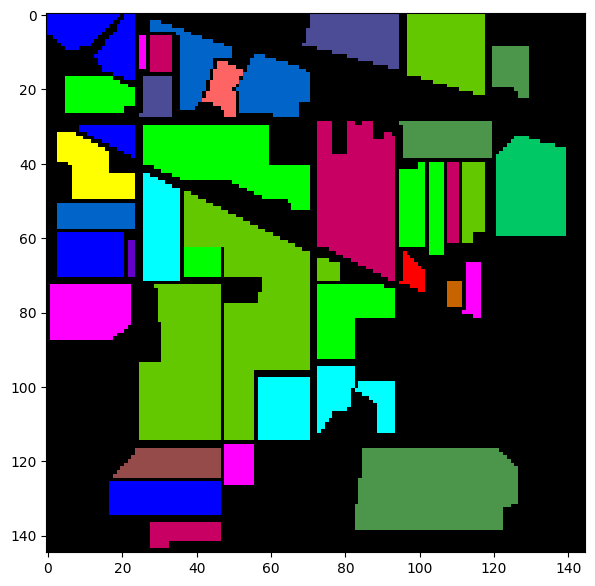

In [29]:
ground_truth = spectral.imshow(classes = Y, figsize =(7,7))

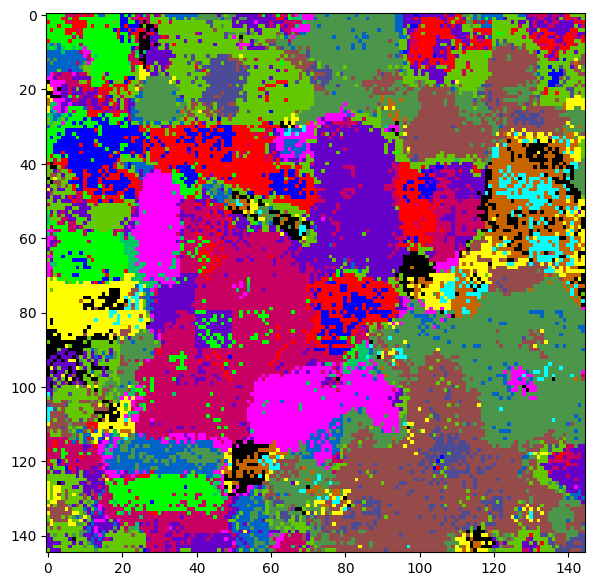

In [30]:
predict_image = spectral.imshow(classes = predictions.astype(int), figsize =(7, 7))